In [37]:
import gzip
import json
from Bio import SeqIO

with gzip.open("res/go.json.gz") as f:
    ontology = json.load(f)

parents = {}  # { term : list_of_parent_terms }
for edge in ontology["graphs"][0]["edges"]:
    # select only is_a edges
    if edge["pred"] == "is_a":
        parents.setdefault(edge["sub"].split("_")[1], []).append(edge["obj"].split("_")[1])

nodes = []  # list of terms
labels = {}  # { term : definition }
for node in ontology["graphs"][0]["nodes"]:
    # exclude obsolete terms
    if "GO_" in node["id"] and "deprecated" not in node["meta"]:
        nodes.append(node["id"].split("_")[1])
        labels[node["id"].split("_")[1]] = node["lbl"]

# Build an ancestors dictionary
ancestors = {}  # { term : list_of_ancestor_terms }
for node in nodes:
    node_ancestors = []
    node_parents = parents.get(node)
    # Loop parent levels until no more parents
    while node_parents:
        node_ancestors.extend(node_parents)
        # Get the parents of current parents (1 level up)
        node_parents = [term for parent in node_parents for term in parents.get(parent, [])]
    ancestors[node] = node_ancestors


# *** Build a dictionary for the children (similar to the ancestors one) efficiently
children = {}  # { node : list_of_children }, leaf terms are not keys
for node in ancestors:
    for ancestor in ancestors[node]:
        children.setdefault(ancestor, set()).add(node)

In [38]:
def get_dataset(path):
    dataset = []
    with open(path, 'r') as f:
        for line in f:
            dataset.append(line[:-1])
    return dataset

In [39]:
def gen_block(f):
    """
    Parse and split the input.
    The input must be sorted by target name, second column.

    UniProtKB       A0A024R1R8      hCG_2014768             GO:0002181      PMID:21873635   IBA     PANTHER:PTN002008372|SGD:S000007246     P       HCG2014768, isoform CRA_a       hCG_2014768     protein taxon:9606      20171102        GO_Central
    UniProtKB       A0A024RBG1      NUDT4B          GO:0003723      GO_REF:0000037  IEA     UniProtKB-KW:KW-0694    F       Diphosphoinositol polyphosphate phosphohydrolase NUDT4B NUDT4B  protein taxon:9606      20191109        UniProt
    UniProtKB       A0A024RBG1      NUDT4B          GO:0005829      GO_REF:0000052  IDA             C       Diphosphoinositol polyphosphate phosphohydrolase NUDT4B NUDT4B  protein taxon:9606      20161204        HPA
    """
    name, old_name = None, None
    chunk = []
    for line in f:
        line = line.decode()
        if line and line[0] != "!":
            _, name, _, _, term, _, ec, _, namespace, protein_name = line.split("\t")[:10]
            term = term[3:]  # remove "GO:" from the term ID
            if name != old_name and old_name:
                yield old_name, set(chunk)  # return a set as there can be repetitions, i.e. the same term with different evidence codes
                chunk = []
            old_name = name
            chunk.append(term)
    # Last line
    if old_name:
        yield old_name, set(chunk)

In [45]:
def annotate_proteins(path, dataset=None):
    if path:
        dataset = get_dataset(path)
    protein_annotated = {}
    with gzip.open("res/goa_human.gaf.gz") as f:
        for acc, annotations in gen_block(f):
            if acc in dataset:
                for term in annotations:
                    protein_annotated.setdefault(acc, set()).add(term)
    return protein_annotated

In [46]:
dataset_files = ["datasets/original.txt", "datasets/pdb.txt", "datasets/string.txt"]
proteins_with_annotations = annotate_proteins(dataset_files[0])
    
fasta_sequences = SeqIO.parse(open('Swiss_Human/Swiss_human.fasta'),'fasta')
human_proteins_swiss = []
for fasta in fasta_sequences:
    name = fasta.id
    proteins = name.split("|")[1]
    human_proteins_swiss.append(proteins)

human_proteins_swiss_annotated = annotate_proteins(None, human_proteins_swiss)

19279


In [64]:
import copy
counts = {}
dataset = get_dataset(dataset_files[0])
with gzip.open("res/goa_human.gaf.gz") as f:
    for acc, annotations in gen_block(f):
        terms_ancestors = copy.copy(annotations)  # annotations + ancestor terms
        if acc in dataset:
            for term in annotations:
                terms_ancestors.update(set(ancestors.get(term, [])))  # add ancestors

            for term in terms_ancestors:  # This time count also ancestors
                counts.setdefault(term, 0)
                counts[term] += 1

counts = {k: v for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)}
print(len(counts))
most_enriched = dict(filter(lambda item: int(item[1]) > 40, counts.items()))
print(most_enriched)

3354
116


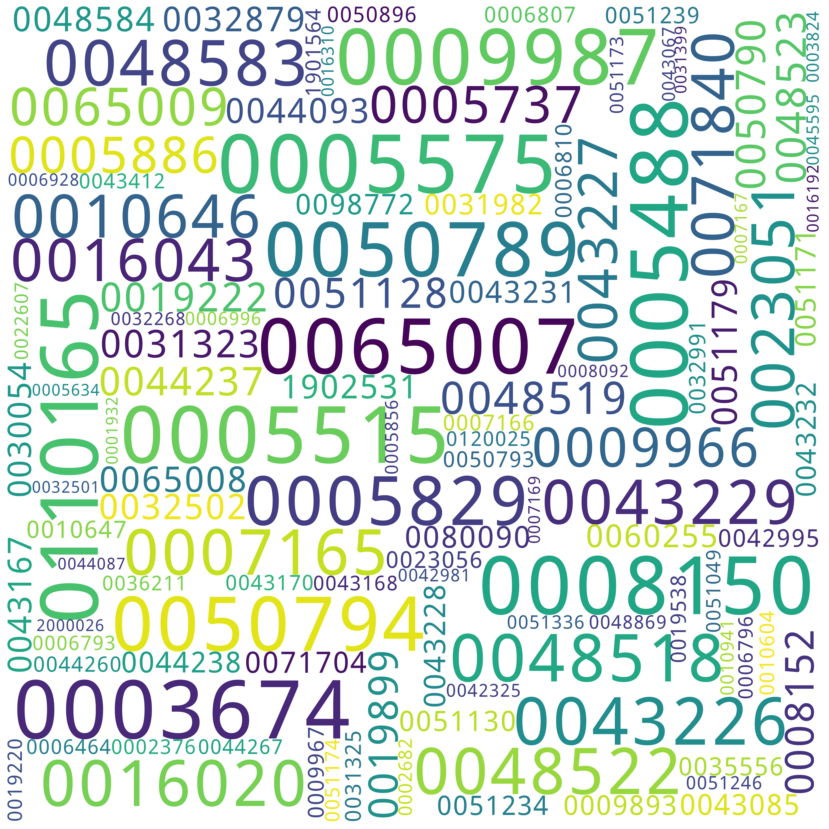

In [96]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(max_font_size=200, max_words=116, width=2000, height=2000, background_color="white", scale=4).generate_from_frequencies(most_enriched)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.xticks([],[])
plt.yticks([],[])
plt.savefig('plot/wordcloud_original.pdf')
plt.axis("off")
plt.show()